In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import copy

from collections import defaultdict 

from synthesizer import Synthesizer
from generator import Generator
from algorithm import Algorithm

# warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 80

### Эксперимент

In [2]:
# seeds = 5 * np.arange(2, 6) + 111

#### Фиксированные параметры генератора
- series_type = "default"  // обычная линейная регрессия

- dim=10 // размерность сигнала
- low=-10, high=10 // границы весов для получения отклика
- noise_var=1 // дисперсия нормального шума
- workers_num=3 // число различных генераторов
- lower_bound=50, upper_bound=200 // границы длин каждого из кусков, получаемых генератором
- alternating=True // нет двух подряд кусков одного типа
#### Фиксированные параметры алгоритма
- from_start=False // начинаем подсчет всех потерь (и составного эксперта) не с самого начала, а после того как прошли по одному разу учатки каждого из  генераторов

- length=1500 // длина изучаемого участка временного ряда

- a=-40, b=40 // параметры алгоритма, отклики отсеиваем тоже по ним

#### Гиперпараметры эксперимента
- windows = [5, 10, 20] // варьируем длину окна обучения ($\frac12x, 1x, 2x$ соответственно, где $x$  &mdash; dim  сигнала )
- weights_function // функция начальных весов, cравниваем $\dfrac1{x^\alpha}$ для разных $\alpha$ и дефолтную $\dfrac{1}{(x+1)\ln^2(x+1)}$
- alpha_function // функция коэффицента $\alpha$ в Mixing Update, cравниваем $\dfrac1{(1 + x)^\alpha}$ для разных $\alpha$

In [12]:
from hypers import weight_hypers
from hypers import alpha_hypers 

from main import results
from main import df

In [14]:
df

,train_window,weight_function,alpha_function,mean,random_1,random_2,random_3,random_4
5,5,1 / ((x + 1) * (ln(x + 1))^2),1 / (x + 1),235135.48,239444.02,198209.12,267607.19,235281.57
3,5,1 / (x^1.001),1 / (x + 1),190819.44,190700.95,162997.91,210267.49,199311.42
7,5,1 / (x^1.01),1 / (x + 1),190184.28,190122.27,162227.69,209655.72,198731.46
4,5,1 / (x^1.01),1 / (x + 1)^1.3,166154.00,170966.07,134417.11,185983.37,173249.44
6,5,1 / (x^1.01),1 / ((x + 1)*(ln(x + 1))^2),135296.21,165184.09,40253.48,174482.82,161264.46
2,5,1 / (x^1.01),1 / e^x,133224.39,165339.42,37392.26,171568.82,158597.05
0,5,1 / (x^1.01),1 / e^(x/3),133225.94,165340.95,37392.05,171568.85,158601.91
1,5,1 / (x^1.1),1 / (x + 1),194532.69,195382.82,164837.91,215724.05,202185.99
13,10,1 / ((x + 1) * (ln(x + 1))^2),1 / (x + 1),183257.14,180371.38,162705.3,199049.29,190902.58
11,10,1 / (x^1.001),1 / (x + 1),129067.96,120891.72,116613.22,134385.77,144381.15


In [13]:
df.to_csv("df-other.csv", sep='\t')

In [5]:
df_w = df[df["alpha_function"] == "1 / (x + 1)"].iloc[:, :4]
df_w

,train_window,weight_function,alpha_function,mean
5,5,1 / ((x + 1) * (ln(x + 1))^2),1 / (x + 1),235135.48
3,5,1 / (x^1.001),1 / (x + 1),190819.44
7,5,1 / (x^1.01),1 / (x + 1),190184.28
1,5,1 / (x^1.1),1 / (x + 1),194532.69
13,10,1 / ((x + 1) * (ln(x + 1))^2),1 / (x + 1),183257.14
11,10,1 / (x^1.001),1 / (x + 1),129067.96
15,10,1 / (x^1.01),1 / (x + 1),128692.52
9,10,1 / (x^1.1),1 / (x + 1),134971.88
21,20,1 / ((x + 1) * (ln(x + 1))^2),1 / (x + 1),182775.02
19,20,1 / (x^1.001),1 / (x + 1),126549.10


In [15]:
df_a = df[df["weight_function"] == "1 / (x^1.01)"].iloc[:,:4]
df_a

,train_window,weight_function,alpha_function,mean
7,5,1 / (x^1.01),1 / (x + 1),190184.28
4,5,1 / (x^1.01),1 / (x + 1)^1.3,166154.00
6,5,1 / (x^1.01),1 / ((x + 1)*(ln(x + 1))^2),135296.21
2,5,1 / (x^1.01),1 / e^x,133224.39
0,5,1 / (x^1.01),1 / e^(x/3),133225.94
15,10,1 / (x^1.01),1 / (x + 1),128692.52
12,10,1 / (x^1.01),1 / (x + 1)^1.3,121927.84
14,10,1 / (x^1.01),1 / ((x + 1)*(ln(x + 1))^2),132777.02
10,10,1 / (x^1.01),1 / e^x,142611.45
8,10,1 / (x^1.01),1 / e^(x/3),142614.39


In [7]:
df[["train_window", "mean"]].groupby("train_window").mean()

,mean
train_window,
5,172321.55375
10,139490.02500
20,167159.64875


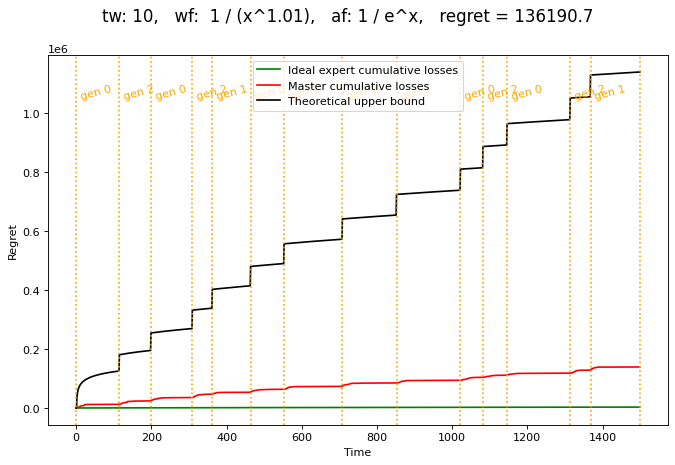

In [8]:
i = 10
results[i].algo.draw_all(show=["master", "ideal", "theoretical"], show_experts=[], 
                              show_axes=["regret"], height_ratios=[1], 
                             suptitle=f"tw: {results[i].train_window},   wf:  {weight_hypers[results[i].key_w].repr},   af: {alpha_hypers[results[i].key_a].repr},   regret = {results[i].algo.regret:.1f}", 
                             fig_size=(10, 6))

In [9]:
# for i in df_w.index:
#     results[i].algo.draw_all(show=["master", "ideal", "theoretical"], show_experts=[], 
#                               show_axes=["regret"], height_ratios=[1], 
#                              suptitle=f"tw: {results[i].train_window},   wf:  {weight_hypers[results[i].key_w].repr},  regret = {results[i].algo.regret:.1f}", 
#                              fig_size=(6, 4))

In [10]:
# for i in df_a.index:
#     results[i].algo.draw_all(show=["master", "ideal", "theoretical"], show_experts=[], 
#                               show_axes=["regret"], height_ratios=[1], 
#                                 suptitle=f"tw: {results[i].train_window},   af:  {alpha_hypers[results[i].key_a].repr},  regret = {results[i].algo.regret:.1f}", 
#                              fig_size=(6, 4))

In [11]:
# i = 13
# results[i].algo.draw_all(show=["master", "ideal", "theoretical"], show_experts=[], 
#                               show_axes=["regret"], height_ratios=[1], 
#                              suptitle=f"tw: {results[i].train_window},   wf:  {weight_hypers[results[i].key_w].repr},  regret = {results[i].algo.regret:.1f}", 
#                              fig_size=(6, 4))

In [ ]:
df